Generating Discrete fBm Paths (H=0.8, FFT Method)...

--- Physics Clash: Initialization Strategies on Fractal Paths ---
[fractal] Epoch 0: Last Loss = 6.9062
[fractal] Epoch 10: Last Loss = 5.3233
[fractal] Epoch 20: Last Loss = 5.0953
[exponential] Epoch 0: Last Loss = 6.9018
[exponential] Epoch 10: Last Loss = 5.3497
[exponential] Epoch 20: Last Loss = 5.0881
[random] Epoch 0: Last Loss = 6.9132
[random] Epoch 10: Last Loss = 5.4546
[random] Epoch 20: Last Loss = 5.1717
Done. Saved to fractal_init_comparison_fbm.png


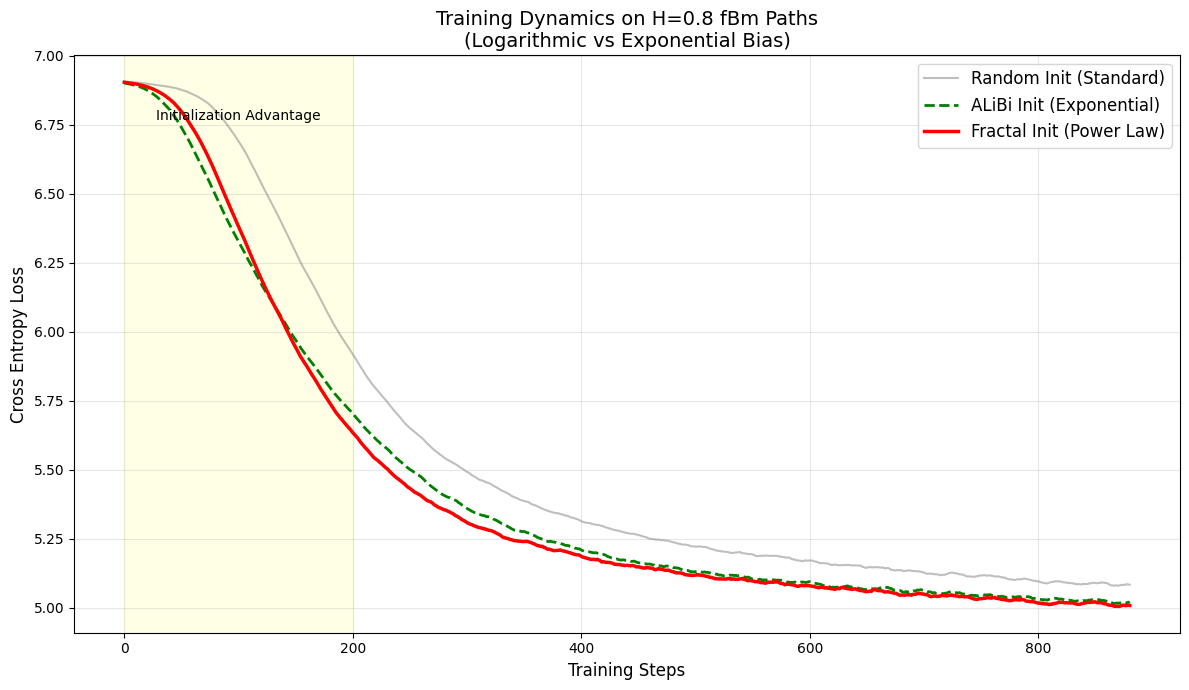

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math  # Added missing import
# from fbm import FBM # 不再使用 fbm 库，改用更底层的 FFT 方法

# ==========================================
# 1. 升级版数据生成器：FFT 合成 fBm (路径)
# ==========================================
def generate_quantized_fbm(n_samples, seq_len, vocab_size, hurst=0.8):
    """
    使用谱合成法 (Spectral Synthesis) 生成分数布朗运动 (fBm)。
    fBm 是路径 (Path)，比 fGn (噪声) 具有更强的长程依赖和全局结构。
    这能最大化 Fractal Bias 的优势。
    """
    print(f"Generating Discrete fBm Paths (H={hurst}, FFT Method)...")
    
    # 1. 计算功率谱密度 S(f) ~ 1/f^beta
    # 对于 fBm, beta = 2H + 1
    beta = 2 * hurst + 1
    
    # 2. 生成频率分量
    # rfftfreq 生成 [0, 1, ..., n/2] 的频率
    freqs = np.fft.rfftfreq(seq_len)
    
    # 3. 构造幅度谱
    # 避免 f=0 时的除零错误，加一个小 epsilon
    scale = 1.0 / (freqs + 1e-10)**(beta / 2.0)
    scale[0] = 0  # 去除直流分量 (0频)
    
    # 4. 生成随机相位 (白噪声)
    # [n_samples, seq_len]
    white_noise = np.random.randn(n_samples, seq_len)
    
    # 5. FFT 变换 -> 频域滤波 -> IFFT 逆变换
    white_fft = np.fft.rfft(white_noise, axis=1)
    # 乘以 1/f^beta 的幅度响应
    colored_fft = white_fft * scale
    fbm = np.fft.irfft(colored_fft, n=seq_len, axis=1)
    
    # 6. 归一化并量化为 Token
    data = np.zeros((n_samples, seq_len), dtype=np.int64)
    for i in range(n_samples):
        s = fbm[i]
        # Min-Max 归一化到 [0, 1]
        s_norm = (s - s.min()) / (s.max() - s.min() + 1e-8)
        # 量化
        tokens = (s_norm * (vocab_size - 1)).astype(np.int64)
        data[i] = tokens
        
    return torch.tensor(data, dtype=torch.long)

# ==========================================
# 2. 支持“分形初始化”的 Transformer
# ==========================================
class InitBiasTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, seq_len, init_mode='random'):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        
        # 词嵌入 & 位置编码
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model) * 0.02)
        
        # 单头 Self-Attention 组件
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.fc = nn.Linear(d_model, vocab_size) # 输出层
        
        # --- 核心：可学习的 Attention Bias ---
        # 形状: [Seq, Seq]
        self.attn_bias = nn.Parameter(torch.zeros(seq_len, seq_len))
        
        # --- 不同的初始化策略 ---
        self._initialize_bias(init_mode)
        
        self.scale = 1.0 / math.sqrt(d_model)
        
        # Causal Mask (下三角)
        mask = torch.tril(torch.ones(seq_len, seq_len))
        mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, 0.0)
        self.register_buffer("mask", mask)

    def _initialize_bias(self, mode):
        with torch.no_grad():
            # 生成距离矩阵: dist[i, j] = |i - j|
            positions = torch.arange(self.seq_len).float().unsqueeze(1)
            dist = torch.abs(positions - positions.T)
            
            if mode == 'fractal':
                # 分形初始化: Bias ~ -log(dist)
                # 系数 0.5 是根据 SOC 理论经验选取的
                fractal_bias = -torch.log(dist + 1.0) * 0.5
                self.attn_bias.copy_(fractal_bias)
                
            elif mode == 'exponential': # ALiBi style
                # 指数初始化: Bias ~ -dist
                # 斜率 0.05 (对应 Notebook 中的设置，太大会直接扼杀长程)
                exp_bias = -0.05 * dist
                self.attn_bias.copy_(exp_bias)
                
            elif mode == 'random':
                nn.init.normal_(self.attn_bias, mean=0.0, std=0.02)
                
            elif mode == 'zero':
                nn.init.zeros_(self.attn_bias)

    def forward(self, x):
        # x: [Batch, Seq] (Token IDs)
        B, L = x.shape
        
        # Embedding
        h = self.embedding(x) + self.pos_embedding[:, :L, :]
        
        # Q, K, V
        q = self.W_q(h)
        k = self.W_k(h)
        v = self.W_v(h)
        
        # Attention Scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        
        # --- 注入可学习的 Bias ---
        scores = scores + self.attn_bias[:L, :L]
        
        # Causal Masking
        scores = scores + self.mask[:L, :L]
        
        attn_weights = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn_weights, v)
        
        # Prediction
        logits = self.fc(out) # [Batch, Seq, Vocab]
        return logits

# ==========================================
# 3. 训练脚本 (分类任务)
# ==========================================
def train_model(init_mode, train_data, vocab_size, d_model, epochs=50):
    seq_len = train_data.shape[1]
    model = InitBiasTransformer(vocab_size, d_model, seq_len, init_mode)
    
    # 使用 AdamW 优化器
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    losses = []
    
    inputs = train_data[:, :-1]
    targets = train_data[:, 1:]
    
    batch_size = 32
    n_samples = len(train_data)
    n_batches = n_samples // batch_size
    
    model.train()
    # 记录 Step 级 Loss 以获得更平滑的曲线
    for epoch in range(epochs):
        indices = torch.randperm(n_samples)
        
        for i in range(n_batches):
            batch_idx = indices[i*batch_size : (i+1)*batch_size]
            batch_in = inputs[batch_idx]
            batch_tgt = targets[batch_idx]
            
            optimizer.zero_grad()
            logits = model(batch_in)
            
            loss = criterion(logits.reshape(-1, vocab_size), batch_tgt.reshape(-1))
            
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
        if epoch % 10 == 0:
            print(f"[{init_mode}] Epoch {epoch}: Last Loss = {losses[-1]:.4f}")
            
    return losses

if __name__ == "__main__":
    # 配置
    SEQ_LEN = 128
    D_MODEL = 64
    VOCAB_SIZE = 1000 # 量化精度
    N_SAMPLES = 1000 # 增加样本数以稳定训练
    EPOCHS = 30 # 减少 Epoch，因为我们看的是 Step 级曲线
    
    # 1. 生成离散分形路径数据 (fBm, Path)
    data = generate_quantized_fbm(N_SAMPLES, SEQ_LEN, VOCAB_SIZE, hurst=0.8)
    
    print("\n--- Physics Clash: Initialization Strategies on Fractal Paths ---")
    
    # 2. 训练对比
    # A. Fractal Init (Power Law)
    loss_fractal = train_model('fractal', data, VOCAB_SIZE, D_MODEL, EPOCHS)
    
    # B. Exponential Init (ALiBi)
    loss_exp = train_model('exponential', data, VOCAB_SIZE, D_MODEL, EPOCHS)
    
    # C. Random Init (Standard)
    loss_rand = train_model('random', data, VOCAB_SIZE, D_MODEL, EPOCHS)
    
    # 3. 绘图
    def smooth(y, box_pts=50):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='valid')
        return y_smooth

    plt.figure(figsize=(12, 7))
    plt.plot(smooth(loss_rand), 'gray', alpha=0.5, label='Random Init (Standard)')
    plt.plot(smooth(loss_exp), 'g--', linewidth=2, label='ALiBi Init (Exponential)')
    plt.plot(smooth(loss_fractal), 'r-', linewidth=2.5, label='Fractal Init (Power Law)')
    
    plt.title(f'Training Dynamics on H=0.8 fBm Paths\n(Logarithmic vs Exponential Bias)', fontsize=14)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Cross Entropy Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 标注差异
    plt.axvspan(0, 200, color='yellow', alpha=0.1)
    plt.text(100, max(smooth(loss_fractal))*0.98, "Initialization Advantage", ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('fractal_init_comparison_fbm.png')
    print("Done. Saved to fractal_init_comparison_fbm.png")